In [0]:
%config IPCompleter.greedy=True

In [0]:
import numpy as np
np.random.seed(42)

In [0]:
class Layer:

  def __init__(self):
    pass
  
  def forward(sefl,input):
    return input

  def backward(self,input,grad_output):
    num_units=input.shape[1]
    d_layer_d_input=np.eye(num_units)
    return np.dot(grad_output,d_layer_d_input)

In [0]:
class ReLU(Layer):

  def __init__(self):
    pass

  def forward(self,input):
    return np.maximum(input,np.zeros((input.shape)))

  def backward(self,input,grad_output):
    relu_grad=input>0
    return grad_output*relu_grad
    

In [0]:
def eval_numerical_gradient(f,x,verbose=False,h=0.00001):
  fx=f(x)
  grad=np.zeros_like(x)
  it=np.nditer(x,flags=['multi_index'],op_flags=['readwrite'])
  while not it.finished:
    ix=it.multi_index
    oldval=x[ix]
    x[ix]=oldval+h
    fxph=f(x)
    x[ix]=oldval-h
    fxmh=f(x)
    x[ix]=oldval
    grad[ix]=(fxph-fxmh)/(2*h)
    
    if verbose:
      print(ix,grad[ix])
    it.iternext()
  return grad

In [0]:
x=np.linspace(-1,1,10*32).reshape([10,32])
l=ReLU()
grads=l.backward(x,np.ones([10,32])/(32*10))
numeric_grads=eval_numerical_gradient(lambda x:l.forward(x).mean(),
                                      x=x)
assert np.allclose(grads,numeric_grads,rtol=1e-3,atol=0),\
'gradient returned by your layer does not match the numerically \
computed gradient'

In [30]:
np.ones((3,5)).dot(np.ones(5))

array([5., 5., 5.])

array([5., 5., 5.])

In [0]:
class Dense(Layer):

  def __init__(self,input_units,output_units,learning_rate=0.1,initialization='random'):
    self.learning_rate=learning_rate
    if initialization=='random':
      self.weights=np.random.randn(input_units,output_units)*0.01
    elif initialization=='xavier':
      self.weights=np.random.normal(loc=0,scale=1./input_units,
                                    size=(input_units,output_units))
    self.biases=np.zeros(output_units)

  def forward(self,input):
    return np.dot(input,self.weights)+self.biases

  def backward(self,input,grad_output):
    grad_input=grad_output.dot(self.weights.T)
    grad_weights=input.T.dot(grad_output)
    grad_biases=grad_output.sum(0)
    assert grad_weights.shape==self.weights.shape
    assert grad_biases.shape==self.biases.shape

    self.weights=self.weights-self.learning_rate*grad_weights
    self.biases=self.biases-self.learning_rate*grad_biases
    return grad_input

In [32]:
l=Dense(128,150)

assert -0.05<l.weights.mean()<0.05 and 1e-3<l.weights.std() <1e-1,\
'The initial weights must have zero mean and small variance.'\
'If you know what you are doing, remove this assertion'

l=Dense(3,4)
x=np.linspace(-1,1,2*3).reshape([2,3])
l.weights=np.linspace(-1,1,3*4).reshape([3,4])
l.biases=np.linspace(-1,1,4)

assert np.allclose(l.forward(x),np.array([[ 0.07272727,  0.41212121,  0.75151515,  1.09090909],
                                          [-0.90909091,  0.08484848,  1.07878788,  2.07272727]]))
print('well done')

well done
well done


In [33]:
def compute_out_given_wb(w,b):
  l=Dense(32,64,learning_rate=1)
  l.weights=np.array(w)
  l.biases=np.array(b)
  x=np.linspace(-1,1,10*32).reshape([10,32])
  return l.forward(x)

def compute_grad_by_params(w,b):
  l=Dense(32,64,learning_rate=1)
  l.weights=np.array(w)
  l.biases=np.array(b)
  x=np.linspace(-1,1,10*32).reshape([10,32])
  l.backward(x,np.ones([10,64])/10.)
  return w-l.weights,b-l.biases

w,b=np.random.randn(32,64),np.linspace(-1,1,64)

numeric_dw=eval_numerical_gradient(lambda w:
                                   compute_out_given_wb(w,b).mean(0).sum(),w)
numeric_db=eval_numerical_gradient(lambda b:
                                   compute_out_given_wb(w,b).mean(0).sum(),b)
grad_w,grad_b=compute_grad_by_params(w,b)
assert np.allclose(numeric_dw,grad_w,rtol=1e-3,atol=0),\
'weight gradient does not match numeric weight gradient'
assert np.allclose(numeric_db,grad_b,rtol=1e-3,atol=0),\
'bias gradient does not match numeric bias gradient'
print('well done')

well done
well done


In [0]:
def softmax_crossentropy_with_logits(logits,reference_answers):
  logits_for_answers=logits[np.arange(len(logits)),reference_answers]
  xentropy=-logits_for_answers+np.log(np.sum(np.exp(logits),axis=-1))
  return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
  ones_for_answers=np.zeros_like(logits)
  ones_for_answers[np.arange(len(logits)),reference_answers]=1
  softmax=np.exp(logits)/np.exp(logits).sum(axis=-1,keepdims=True)
  return (-ones_for_answers+softmax)/logits.shape[0]

In [0]:
logits=np.linspace(-1,1,500).reshape([50,10])
answers=np.arange(50)%10
softmax_crossentropy_with_logits(logits,answers)
grads=grad_softmax_crossentropy_with_logits(logits,answers)
numeric_grads=eval_numerical_gradient(lambda l:
                                      softmax_crossentropy_with_logits(
                                          l,answers
                                      ).mean(),logits)
assert np.allclose(numeric_grads,grads,rtol=1e-3,atol=0),\
"The reference implementation has just failed. Someone has just changed the rules of math."

In [36]:
import keras

def load_dataset(flatten=False):
  (X_train,y_train),(X_test,y_test)=keras.datasets.mnist.load_data()

  X_train=X_train.astype(float)/255.
  X_test=X_test.astype(float)/255.

  X_train,X_val=X_train[:-10000],X_train[-10000:]
  y_train,y_val=y_train[:-10000],y_train[-10000:]

  if flatten:
    X_train=X_train.reshape([X_train.shape[0],-1])
    X_val=X_val.reshape([X_val.shape[0],-1])
    X_test=X_test.reshape([X_test.shape[0],-1])

  return X_train,y_train,X_val,y_val,X_test,y_test

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step


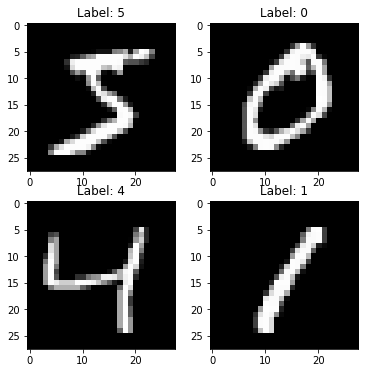

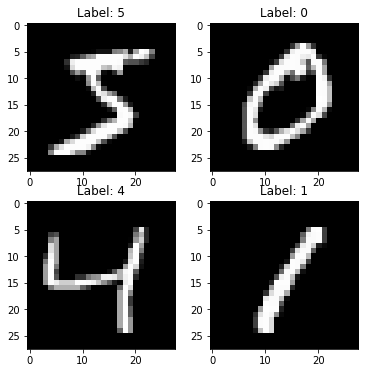

In [37]:
import matplotlib.pyplot as plt

X_train,y_train,X_val,y_val,X_test,y_test=load_dataset(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.title('Label: %i'%y_train[i])
  plt.imshow(X_train[i].reshape([28,28]),cmap='gray')


In [0]:
network=[]
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,200))
network.append(ReLU())
network.append(Dense(200,10))

In [0]:
def forward(network,X):
  activations=[]
  input=X
  activation=X
  for layer in network:
    activation=layer.forward(activation)
    activations.append(activation)
  
  assert len(activations)==len(network)
  return activations

def predict(network,X):
  logits=forward(network,X)[-1]
  return logits.argmax(axis=-1)

def train(network,X,y):
  layer_activations=forward(network,X)
  layer_inputs=[X]+layer_activations
  logits=layer_activations[-1]

  loss=softmax_crossentropy_with_logits(logits,y)
  loss_grad=grad_softmax_crossentropy_with_logits(logits,y)

  grad_output=loss_grad
  for layer,input in zip(network[::-1],layer_activations[-2::-1]):
    grad_output=layer.backward(input,grad_output)

  return np.mean(loss)

In [40]:
list(np.arange(10))[:1:-1]

[9, 8, 7, 6, 5, 4, 3, 2]

[9, 8, 7, 6, 5, 4, 3, 2]

In [0]:
from tqdm import tqdm

def iterate_minibatches(inputs,targets,batchsize,shuffle=False):
  assert len(inputs)==len(targets)
  if shuffle:
    indices=np.random.permutation(len(inputs))
  for start_idx in tqdm(range(0,len(inputs)-batchsize+1,batchsize)):
    if shuffle:
      excerpt=indices[start_idx:start_idx+batchsize]
    else:
      excerpt=slice(start_idx,start_idx+batchsize)
    yield inputs[excerpt],targets[excerpt]

In [0]:
from IPython.display import clear_output


Epoch 45
Train accuracy: 0.93298
Val accuracy: 0.934
[ 0.01020897 -0.00154964  0.01366659 -0.00288179  0.00652704]


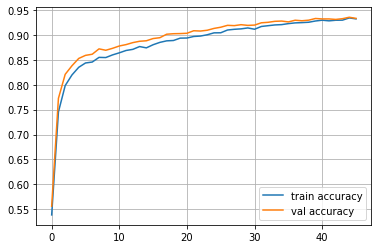

  5%|▌         | 79/1562 [00:00<00:01, 789.47it/s]

In [19]:
%%time
train_log=[]
val_log=[]
for epoch in range(50):
  for x_batch,y_batch in iterate_minibatches(X_train,y_train,
                                             batchsize=32,shuffle=True):
    train(network,x_batch,y_batch)
  train_log.append(np.mean(predict(network,X_train)==y_train))
  val_log.append(np.mean(predict(network,X_val)==y_val))

  clear_output()
  print('Epoch',epoch)
  print('Train accuracy:',train_log[-1])
  print('Val accuracy:',val_log[-1])
  print(network[0].weights[0,:5])
  plt.plot(train_log,label='train accuracy')
  plt.plot(val_log,label='val accuracy')
  plt.legend(loc='best')
  plt.grid()
  plt.show()

In [0]:
network=[]
network.append(Dense(X_train.shape[1],100,initialization='xavier'))
network.append(ReLU())
network.append(Dense(100,200,initialization='xavier'))
network.append(ReLU())
network.append(Dense(200,10,initialization='xavier'))

Epoch 49
Train accuracy: 0.81964
Val accuracy: 0.8394
[ 0.00114153 -0.00035052  0.00138476  0.00046965  0.00024082]


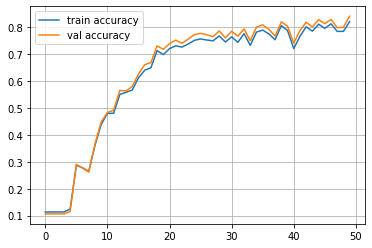

CPU times: user 3min 9s, sys: 1min 26s, total: 4min 36s
Wall time: 2min 25s


In [21]:
%%time
train_log=[]
val_log=[]
for epoch in range(50):
  for x_batch,y_batch in iterate_minibatches(X_train,y_train,
                                             batchsize=32,shuffle=True):
    train(network,x_batch,y_batch)
  train_log.append(np.mean(predict(network,X_train)==y_train))
  val_log.append(np.mean(predict(network,X_val)==y_val))

  clear_output()
  print('Epoch',epoch)
  print('Train accuracy:',train_log[-1])
  print('Val accuracy:',val_log[-1])
  print(network[0].weights[0,:5])
  plt.plot(train_log,label='train accuracy')
  plt.plot(val_log,label='val accuracy')
  plt.legend(loc='best')
  plt.grid()
  plt.show()

In [0]:
#%load_ext tensorboard

In [0]:
#%tensorboard --logdir tmp/tboard